# Face Recognation 
Project based on: [Build a Deep Facial Recognition App](https://www.youtube.com/watch?v=bK_k7eebGgc&list=PLgNJO2hghbmhHuhURAGbe6KWpiYZt0AMH)

# 1. Set up and get data

# 1.1 Install dependencies

!pip install tensorflow

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

/bin/bash: pip: command not found


## 1.2 Collect images using openCV

In [2]:
import os
import time
import uuid # for unique id
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model

2024-05-30 09:22:53.657048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
IMAGES_PATH = os.path.join('data', 'images')
NUM_IMAGES_TO_COLLECT = 20

In [ ]:
# Conection to video camera and get images
cap = cv2.VideoCapture(0) # if you are on winodws try 1 instead of 0
for imgnum in range(NUM_IMAGES_TO_COLLECT):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'): # turn off the camera
        break
cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate images with labelMe

In [2]:
#/Users/asialalala/.local/pipx/venvs/labelme/bin/labelme
!labelme

2024-05-28 21:22:42,323 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\biuro\.labelmerc


# 2. Review Dataset and Build Image Loading Function

## 2.1 Import packages

## 2.2 Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# WARNING!!!! It should be trye, but it is false

In [6]:
# check if tensorflow is available
tf.config.list_physical_devices('GPU')
#tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [7]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [8]:
# variable 'images' contains path to images files
images.as_numpy_iterator().next()

b'data/images/4590c526-084f-11ef-b20b-64d2c4ecd148.jpg'

In [9]:
# read images and load them as jpeg to img
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
images = images.map(load_image)

In [11]:
images.as_numpy_iterator().next()

array([[[ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0],
        ...,
        [86, 77, 62],
        [88, 81, 65],
        [87, 81, 65]],

       [[ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0],
        ...,
        [85, 76, 61],
        [87, 79, 66],
        [87, 81, 65]],

       [[ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0],
        ...,
        [87, 77, 65],
        [83, 75, 64],
        [82, 74, 61]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [47, 37, 35],
        [44, 35, 36],
        [44, 35, 36]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [48, 39, 34],
        [46, 38, 36],
        [47, 42, 39]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [50, 43, 35],
        [46, 38, 35],
        [45, 40, 37]]], dtype=uint8)

## 2.4 View Raw Images with Matplotlib

In [15]:
image_genarator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_genarator.next() #geting new batch of data, can be ran multiple time

2024-05-30 09:27:40.492481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [720,1280,3], [batch]: [480,640,3]


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [720,1280,3], [batch]: [480,640,3] [Op:IteratorGetNext] name: 

NameError: name 'plot_images' is not defined

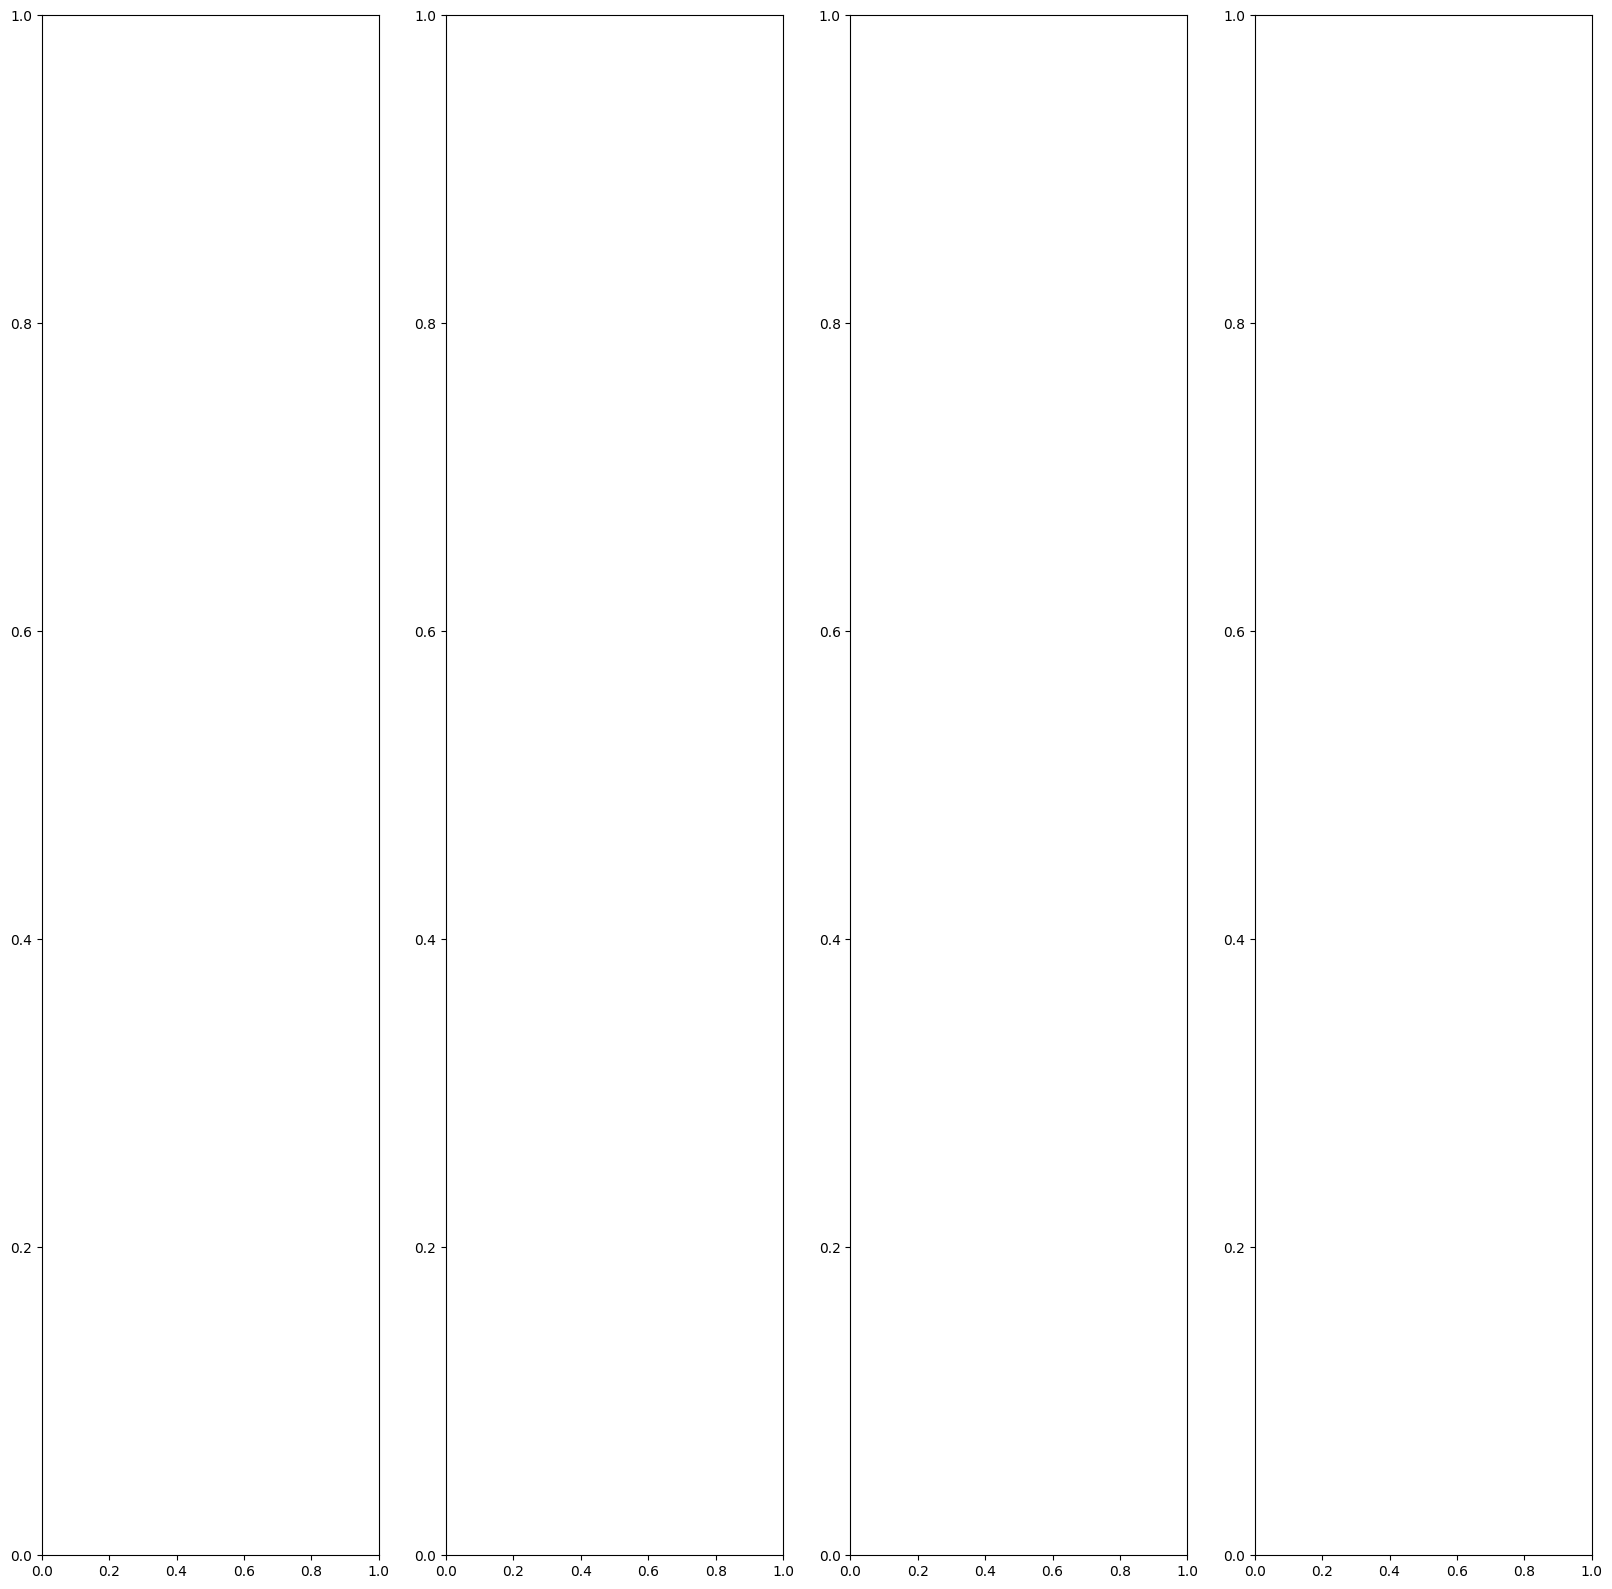

In [12]:
#show 4 images, if you want another butch just ran cell below and then this one
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()                      

# 3. Partition Unaugmented Data

## 3.1 Manually Split Sata into Train Test and Val

In [17]:
#if we add new data we need to also divide it and add to folders

In [18]:
120*0.7 #123 to train + 126 

84.0

In [19]:
120*.15 # 26 and 27 to test and val + 27 and 27

18.0

## 3.2 Move the Matching Labels

In [20]:
#moving matching labels to the photos in new folders
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath) 
#i'm not sure if it do it for all files but it did for some

# 4. Apply Image Augmentation on Images and Labels using Albumentations

## 4.1 Setup Albumentations Transform Pipline

In [21]:
#adjust photos and normalization (bbox)
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))


## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [22]:
img = cv2.imread(os.path.join('data','train','images','d6aac8ad-1cff-11ef-ad8d-a3ac01d69874.jpg')) #if dosen't return error -> works

In [23]:
with open(os.path.join('data','train','labels','d6aac8ad-1cff-11ef-ad8d-a3ac01d69874.json'), 'r') as f:
    label = json.load(f)

In [24]:
#label #to check if it works, also can check type or use label['shapes'] or label['shapes'][0]['points'] for coordinate

In [25]:
label['shapes'][0]['label']


'unknown'

## 4.3 Extract Cooridnates and Rescale to Match Image Resolution

In [26]:
coords = [0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [27]:
coords #vector with coordinates

[222.6595744680851, 67.12765957446811, 430.1063829787234, 342.6595744680851]

In [28]:
#this adjust to picture width and height and works better
img_width = img.shape[1] #x
img_height = img.shape[0] #y
coords = list(np.divide(coords, [img_width, img_height, img_width, img_height]))

In [29]:
coords

[0.347905585106383, 0.1398492907801419, 0.6720412234042553, 0.7138741134751773]

## 4.4 Apply Augmentation and View Results

In [30]:
if label['shapes'][0]['label'] == 'face':
    class_lab = 'face'
elif label['shapes'][0]['label'] == 'Ola':
    class_lab = 'Ola'
else:
    class_lab = 'unknown'

In [31]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=[class_lab]) 

In [32]:
augmented['bboxes']

[(0.07754137115839244,
  0.2852009456264776,
  0.5385342789598109,
  0.8974940898345153)]

In [33]:
len(augmented['bboxes'])

1

In [34]:
type(augmented['image'])

numpy.ndarray

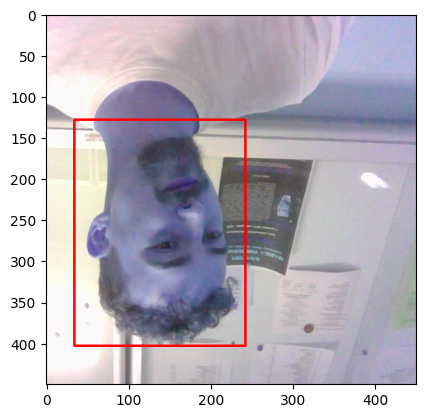

In [35]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image']) #can be blue its still correct

# 5. Bulid and Run Augmentation Pipeline

## 5.1 Run Augmentation Pipeline

In [34]:
for folder in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', folder, 'images')):
        img = cv2.imread(os.path.join('data', folder, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        filename = image.split('.')[0] + '.json'
        label_path = os.path.join('data', folder, 'labels', filename)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            img_width = img.shape[1] # x
            img_height = img.shape[0] # y
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [img_width, img_height, img_width, img_height]))

        try:
            for x in range(60):  #create 60 new images for every image in Database
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                
                new_image_name = f'{image.split(".")[0]}_{x}.jpg'  
                cv2.imwrite(os.path.join('aug_data', folder, 'images', new_image_name), augmented['image'])

                annotation = {}
                annotation['image'] = image  

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bboxes'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        if label['shapes'][0]['label'] == 'face':
                            annotation['bboxes'] = augmented['bboxes'][0]
                            annotation['class'] = 1
                        elif label['shapes'][0]['label'] == 'Ola':
                            annotation['bboxes'] = augmented['bboxes'][0]
                            annotation['class'] = 2
                        else:
                            annotation['bboxes'] = augmented['bboxes'][0]
                            annotation['class'] = 3
                else:
                    annotation['bboxes'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', folder, 'labels', f'{image.split(".")[0]}_{x}.json'), 'w') as f: 
                    json.dump(annotation, f)
        except Exception as e:
            print(e)
                        

image must be numpy array type
image must be numpy array type
image must be numpy array type


KeyboardInterrupt: 

## 5.2 Load Augmented Images to Tensorflow Dataset

In [36]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/225) #scaling and resize towork better at network while teaching

In [37]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/225)

In [38]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/225)

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [39]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']],label['bboxes']

## 6.2 Load Labels to Tensorflow Dataset

In [40]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 7. Combine Label and Image Samples

## 7.1 Check Partition Lengths

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(18360, 18360, 3960, 3960, 3960, 3960)

## 7.2 Create Final Datasets (Images/Labels)

In [44]:
train = tf.data.Dataset.zip((train_images,train_labels)) #combining 
train = train.shuffle(15000) #bigger than len(train_images)
train = train.batch(8) 
train = train.prefetch(4) #eliminate bottlenecks

In [45]:
test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(3500)
test = test.batch(8)
test = test.prefetch(4)

In [46]:
val = tf.data.Dataset.zip((val_images,val_labels))
val = val.shuffle(3500)
val = val.batch(8)
val = val.prefetch(4)

In [47]:
train.as_numpy_iterator().next()[0].shape #8 images, 120x120, 3 colors

2024-05-30 09:30:18.469672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 4433 of 15000
2024-05-30 09:30:28.470567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 8525 of 15000
2024-05-30 09:30:46.674568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


(8, 120, 120, 3)

## 7.3 View Images and Annotation

In [48]:
data_sample=train.as_numpy_iterator()

In [59]:
res = data_sample.next()

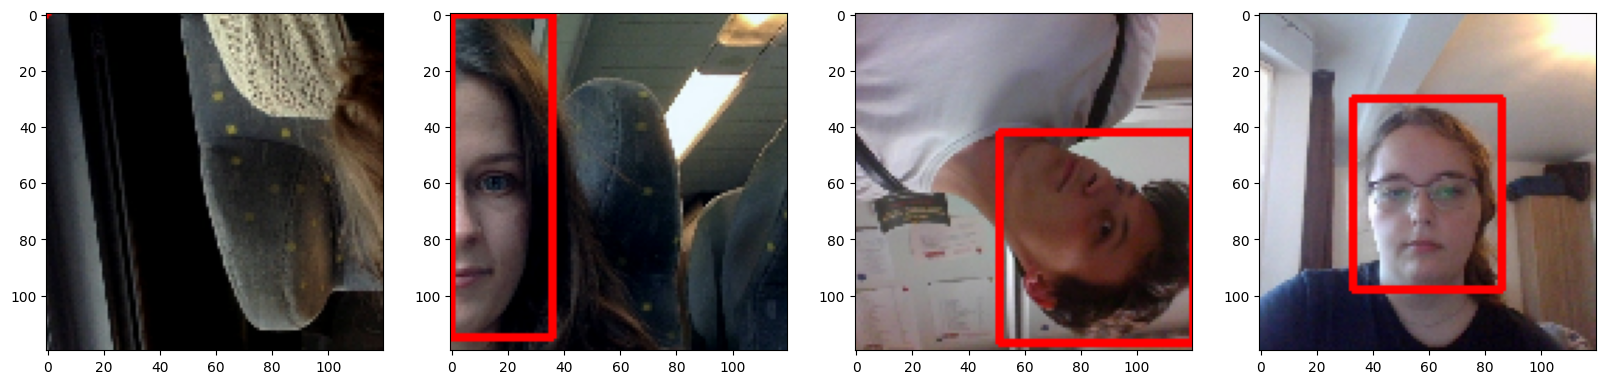

In [60]:
fif, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    # Normalizacja obrazu
    normalized_image_np = cv2.normalize(sample_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    sample_image_umat = cv2.UMat(normalized_image_np)
    # Wywołanie funkcji cv2.rectangle na obiekcie UMat
    cv2.rectangle(sample_image_umat,
              tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
              (255,0,0),2)

    # Wyświetlenie znormalizowanego obrazu
    ax[idx].imshow(sample_image_umat.get())
    # ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

## 8.1 Import Layers and Base Network
Zaimportowane też powyżej (razem ze wszystkimi)

*Czym jest VGG16?*
To model sieci neuronowej konwolucyjnej (CNN).
Model VGG16 składa się z 16 warstw konwolucyjnych i poolingowych, a następnie warstw w pełni połączonych. Każda warstwa konwolucyjna w modelu VGG16 składa się z serii filtrów konwolucyjnych o małym rozmiarze (zazwyczaj 3x3) z funkcją aktywacji ReLU oraz warstw poolingowych, które zmniejszają wymiary przestrzenne map cech.

In [61]:
from tensorflow.keras.models import Model # bazowy model tesoflow
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical #do klasyfikacji

## 8.2 Download VGG16

In [62]:
# odcinamy koniec, bo jest to model tylko do klasyfikacji, a końcówkę chcemy zastąpić regresją
vgg = VGG16(include_top=False)

In [63]:
vgg.summary() # wyświetla informację o sieciach neuronowych
# (ilość próbek, szerokość, wysokość, ilość kanałów)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## 8.3 Build instance of Network

In [64]:
# def build_model(): 
#     input_layer = Input(shape=(120,120,3)) # wejście o wymiarach 120x120x3 pikseli
    
#     vgg = VGG16(include_top=False)(input_layer)

#     # Model klasyfikacji  
#     f1 = GlobalMaxPooling2D()(vgg) # wyjścia w vgg
#     class1 = Dense(2048, activation='relu')(f1)
#     class2 = Dense(1, activation='sigmoid')(class1) # jedno wyjscie
    
#     # Model ramki ograniczającej
#     f2 = GlobalMaxPooling2D()(vgg) # jakoś kondensuje ilość wejść
#     regress1 = Dense(2048, activation='relu')(f2)
#     regress2 = Dense(4, activation='sigmoid')(regress1) # 4 wyjscia
    
#     facetracker = Model(inputs=input_layer, outputs=[class2, regress2]) # dwa wyjścia
#     # wyjście z klasyfikacji i wyjście z regresji
#     # class2 jest jedna wartoscia z przedzialu [0,1] ponieważ wykorzystuję sigmoidę
#     # regress2 sklada się z 4 elementów z przedziału [0,1]
#     return facetracker

In [83]:
def build_model(num_classes): 
    input_layer = Input(shape=(120,120,3)) # wejście o wymiarach 120x120x3 pikseli
    
    vgg = VGG16(include_top=False)(input_layer)

    # Model klasyfikacji  
    f1 = GlobalMaxPooling2D()(vgg) # wyjścia w vgg
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(num_classes, activation='softmax')(class1) # liczba klas wyjściowych
    
    # Model ramki ograniczającej
    f2 = GlobalMaxPooling2D()(vgg) # jakoś kondensuje ilość wejść
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) # 4 wyjscia
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2]) # dwa wyjścia
    # wyjście z klasyfikacji i wyjście z regresji
    # class2 jest prawdopodobieństwem przynależności do każdej klasy, więc używamy softmax jako funkcji aktywacji
    # liczba klas zależy od twojego zbioru danych
    return facetracker

## 8.4 Test out Neural Network

In [84]:
facetracker = build_model(4)#facetracker = build_model() #zdefiniuj model - bo 4 klasy

In [85]:
facetracker.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │      8,196 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │      8,196 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,832,328 (64.21 MB)

 Trainable params: 16,832,328 (64.21 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
X, y = train.as_numpy_iterator().next()

2024-05-30 09:48:07.724977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 3233 of 15000
2024-05-30 09:48:27.723479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 9373 of 15000
2024-05-30 09:48:42.670611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [87]:
y

(array([[0],
        [1],
        [2],
        [1],
        [2],
        [3],
        [3],
        [3]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.2147 , 0.3494 , 0.915  , 0.9976 ],
        [0.5195 , 0.10205, 0.9956 , 0.6777 ],
        [0.2283 , 0.     , 0.9624 , 0.918  ],
        [0.1799 , 0.12177, 0.589  , 0.533  ],
        [0.435  , 0.1305 , 0.911  , 0.7485 ],
        [0.     , 0.1132 , 0.456  , 0.827  ],
        [0.2084 , 0.1818 , 0.7495 , 0.8955 ]], dtype=float16))

In [88]:
X.shape

(8, 120, 120, 3)

In [89]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [90]:
classes, coords

(array([[0.16155285, 0.2485693 , 0.38623932, 0.20363851],
        [0.2398368 , 0.13715233, 0.41462737, 0.20838359],
        [0.14702493, 0.16103685, 0.4668407 , 0.22509763],
        [0.16305315, 0.13293001, 0.542531  , 0.16148588],
        [0.33195692, 0.11514333, 0.29755184, 0.25534797],
        [0.1784202 , 0.15119858, 0.37258208, 0.29779914],
        [0.15443267, 0.17739682, 0.42130786, 0.24686277],
        [0.17472063, 0.12500061, 0.31139624, 0.38888252]], dtype=float32),
 array([[0.53916985, 0.5117541 , 0.5080746 , 0.37201414],
        [0.49844682, 0.535698  , 0.52269834, 0.33991233],
        [0.43436694, 0.640164  , 0.62026316, 0.50438255],
        [0.5383472 , 0.5309828 , 0.45830885, 0.3820394 ],
        [0.580477  , 0.5345646 , 0.53041863, 0.4260976 ],
        [0.4382882 , 0.46754327, 0.6071745 , 0.5020513 ],
        [0.48573777, 0.5874091 , 0.4949654 , 0.31855723],
        [0.41616422, 0.5603119 , 0.5413832 , 0.36920393]], dtype=float32))

# 9. Define Losses and Optimizers

## 9.1 Define Optimizer and LR

In [91]:
batches_per_epoch = len(train) # ilość danych uczących na epokę
lr_decay = (1./0.75 -1)/batches_per_epoch # spadek szybkości uczenia się
print('batches_per_epoch ' + str(batches_per_epoch) )
print('lr_decay ' + str(lr_decay))

batches_per_epoch 2295
lr_decay 0.00014524328249818444


In [92]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [93]:

def localization_loss(y_true, yhat):     
    # różnica pomiędzy rzeczywistym a przewidywanym koordynatem(rogiem)
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    # różnica pomiędzy rzeczywistymi a przewidywanymi długościami prostokąta
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    # zwraxa sumę błędów
    return delta_coord + delta_size

In [94]:
classloss = tf.keras.losses.CategoricalCrossentropy() #zmiana z binary na kategoriowy
regressloss = localization_loss

In [75]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.048916>

In [95]:
y_true_classes = to_categorical(y[0], num_classes=4) # 4 klasy: Asia, Ola, unknown, brak_twarzy

In [96]:
class_loss_value = classloss(y_true_classes, classes)
# classloss(y[0], classes).numpy()

In [97]:
regressloss(y[1], coords)
# regressloss(y[1], coords).numpy()

<tf.Tensor: shape=(), dtype=float32, numpy=9.0897045>

# 10. Train Neural Network

## 10.1 Create Custom Model Class

In [100]:
#gorąca jedynka
def preprocess_labels(y, num_classes):
    y_one_hot = tf.one_hot(y, depth=num_classes)
    y_one_hot = tf.reshape(y_one_hot, (-1, num_classes))  # Upewnij się, że kształt jest poprawny
    return y_one_hot

In [101]:
class FaceTracker(Model): 
    def __init__(self, eyetracker, num_classes, **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker
        self.num_classes = num_classes

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    @tf.function  # Decorate train_step with @tf.function
    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            try:
                classes, coords = self.model(X, training=True)

                # Zakodowanie etykiet w one-hot
                y_0 = preprocess_labels(y[0], self.num_classes)

                # Ustawienie kształtu tensorów
                y_0.set_shape([None, self.num_classes])
                classes.set_shape([None, self.num_classes])

                # Sprawdzenie kształtów tensorów
                tf.print("y_0 shape:", tf.shape(y_0))
                tf.print("classes shape:", tf.shape(classes))

                batch_classloss = self.closs(y_0, classes)
                batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
                total_loss = batch_localizationloss + 0.5 * batch_classloss

            except tf.errors.InvalidArgumentError as e:
                # Obsługuj przypadek, w którym y[0] może mieć rozmiar partii wynoszący zero (opcjonalnie)
                if 'Input tensors must be of size at least 1' in str(e):
                    return {"total_loss": tf.constant(0.0)}  # Dummy loss (opcjonalnie)
                else:
                    raise e  # Zakończ errorem

            grad = tape.gradient(total_loss, self.model.trainable_variables)
            self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    @tf.function  # Decorate test_step with @tf.function
    def test_step(self, batch, **kwargs):
        X, y = batch
        classes, coords = self.model(X, training=False)

        # Zakodowanie etykiet w one-hot
        y_0 = preprocess_labels(y[0], self.num_classes)

        # Ustawienie kształtu tensorów
        y_0.set_shape([None, self.num_classes])
        classes.set_shape([None, self.num_classes])

        # Sprawdzenie kształtów tensorów
        tf.print("y_0 shape:", tf.shape(y_0))
        tf.print("classes shape:", tf.shape(classes))

        batch_classloss = self.closs(y_0, classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}


    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [102]:
# class FaceTracker(Model): 
#     def __init__(self, eyetracker,  **kwargs): 
#         super().__init__(**kwargs)
#         self.model = eyetracker

#     def compile(self, opt, classloss, localizationloss, **kwargs):
#         super().compile(**kwargs)
#         self.closs = classloss
#         self.lloss = localizationloss
#         self.opt = opt

#     @tf.function  # Decorate train_step with @tf.function
#     def train_step(self, batch, **kwargs):
#         X, y = batch

#         with tf.GradientTape() as tape:
#           try:
#             classes, coords = self.model(X, training=True)

#             # Upewnij się, że y[0] ma zdefiniowaną range 
#             y_0 = tf.reshape(y[0], [-1, 1])  # Przykład: w razie potrzeby zmień kształt na (batch_size,1).
#             # Sprawdź format danych i odpowiednio zmień ich kształt

#             # Upewnij się, że klasy mają zdefiniowaną rangę (sprawdź kształt wyjściowy self.model(X,training=True))
#             # ... (w razie potrzeby zmień kształt klas w oparciu o dane wyjściowe modelu)

#             batch_classloss = self.closs(y_0, classes)
#             batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32),coords)
#             total_loss = batch_localizationloss + 0.5 * batch_classloss

#           except tf.errors.InvalidArgumentError as e:
#             # Obsługuj przypadek, w którym y[0] może mieć rozmiar partii wynoszący zero (opcjonalnie)
#             if 'Input tensors must be of size at least 1' in str(e):
#               return {"total_loss": tf.constant(0.0)}  # Dummy loss (opcjonalnie)
#             else:
#               raise e  # Zakończ errorem

#           grad = tape.gradient(total_loss, self.model.trainable_variables)
#           self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

#         return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

#     def test_step(self, batch, **kwargs):
#         X, y = batch
#         classes, coords = self.model(X, training=False)

#         # Ensure y[0] has a defined rank (handle potential reshaping)
#         y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1)if needed
#         # Check your data format and reshape accordingly

#         # Ensure classes has a defined rank (check model output shape)
#         # ... (reshape classes if necessary based on your model's output)

#         batch_classloss = self.closs(y_0, classes)
#         batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
#         total_loss = batch_localizationloss + 0.5 * batch_classloss
#         return {"total_loss": total_loss, "class_loss": batch_classloss,"regress_loss": batch_localizationloss}

#     def call(self, X, **kwargs):
#         return self.model(X, **kwargs)

In [103]:
model = FaceTracker(facetracker,4) #bo aktualnie sa trzy klasy, mozna zmienic 

In [104]:
model.compile(opt, classloss, regressloss)

# 10.2 Train

In [105]:
logdir='logs'

In [106]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [107]:
print("Shape of y[0]:", y[0].shape)
print("Shape of classes:", classes.shape)

Shape of y[0]: (8, 1)
Shape of classes: (8, 4)


In [ ]:
# powoduje wywołanie train_step    ODKOMENTUJ< JESLI CHCESZ UCZYC
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2024-05-30 09:57:48.576487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 3788 of 15000
2024-05-30 09:58:08.577803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 8286 of 15000
2024-05-30 09:58:28.577437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 11325 of 15000
2024-05-30 09:58:38.577744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 13609 of 15000


y_0 shape: [8 4]


2024-05-30 09:58:44.648966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1717055924.825711 5033079 service.cc:145] XLA service 0x60000108f500 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717055924.830926 5033079 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-05-30 09:58:44.840387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1717055925.833569 5033079 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


classes shape: [8 4]
   1/2295 ━━━━━━━━━━━━━━━━━━━━ 54:42:40 86s/step - class_loss: 1.4362 - regress_loss: 8.4482 - total_loss: 9.1663y_0 shape: [8 4]
classes shape: [8 4]
   2/2295 ━━━━━━━━━━━━━━━━━━━━ 3:02:53 5s/step - class_loss: 1.2949 - regress_loss: 4.7667 - total_loss: 5.4142  y_0 shape: [8 4]
classes shape: [8 4]
   3/2295 ━━━━━━━━━━━━━━━━━━━━ 2:51:37 4s/step - class_loss: 1.2812 - regress_loss: 3.7973 - total_loss: 4.4379y_0 shape: [8 4]
classes shape: [8 4]
   4/2295 ━━━━━━━━━━━━━━━━━━━━ 3:10:38 5s/step - class_loss: 1.2538 - regress_loss: 3.1731 - total_loss: 3.8000y_0 shape: [8 4]
classes shape: [8 4]
   5/2295 ━━━━━━━━━━━━━━━━━━━━ 3:08:57 5s/step - class_loss: 1.2584 - regress_loss: 3.0238 - total_loss: 3.6529y_0 shape: [8 4]
classes shape: [8 4]
   6/2295 ━━━━━━━━━━━━━━━━━━━━ 3:02:46 5s/step - class_loss: 1.2571 - regress_loss: 2.8958 - total_loss: 3.5243y_0 shape: [8 4]
classes shape: [8 4]
   7/2295 ━━━━━━━━━━━━━━━━━━━━ 2:58:40 5s/step - class_loss: 1.2688 - regress_los

2024-05-30 12:04:42.942698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:36: Filling up shuffle buffer (this may take a while): 1972 of 3500


y_0 shape: [8 4]


2024-05-30 12:04:47.776594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shap

2024-05-30 12:14:11.552698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 3113 of 15000
2024-05-30 12:14:31.551056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 11110 of 15000
2024-05-30 12:14:41.551712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 14181 of 15000


y_0 shape: [8 4]


2024-05-30 12:14:44.882637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
   1/2295 ━━━━━━━━━━━━━━━━━━━━ 60:44:17 95s/step - class_loss: 4.6141e-04 - regress_loss: 0.0908 - total_loss: 0.0910y_0 shape: [8 4]
classes shape: [8 4]
   2/2295 ━━━━━━━━━━━━━━━━━━━━ 3:42:11 6s/step - class_loss: 9.2289e-04 - regress_loss: 0.1311 - total_loss: 0.1315  y_0 shape: [8 4]
classes shape: [8 4]
   3/2295 ━━━━━━━━━━━━━━━━━━━━ 3:44:40 6s/step - class_loss: 0.0336 - regress_loss: 0.1605 - total_loss: 0.1773    y_0 shape: [8 4]
classes shape: [8 4]
   4/2295 ━━━━━━━━━━━━━━━━━━━━ 3:34:05 6s/step - class_loss: 0.0255 - regress_loss: 0.1497 - total_loss: 0.1625y_0 shape: [8 4]
classes shape: [8 4]
   5/2295 ━━━━━━━━━━━━━━━━━━━━ 3:28:53 5s/step - class_loss: 0.0389 - regress_loss: 0.1521 - total_loss: 0.1715y_0 shape: [8 4]
classes shape: [8 4]
   6/2295 ━━━━━━━━━━━━━━━━━━━━ 3:29:54 6s/step - class_loss: 0.0401 - regress_loss: 0.1498 - total_loss: 0.1698y_0 shape: [8 4]
classes shape: [8 4]
   7/2295 ━━━━━━━━━━━━━━━━━━━━ 3:40:38 6s/step - class_loss: 0.0420 -

2024-05-30 14:52:17.212629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:36: Filling up shuffle buffer (this may take a while): 2851 of 3500


y_0 shape: [8 4]


2024-05-30 14:52:19.256167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shap

2024-05-30 15:01:18.637726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 4609 of 15000
2024-05-30 15:01:28.641615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 8062 of 15000


y_0 shape: [8 4]


2024-05-30 15:01:46.589090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
   1/2295 ━━━━━━━━━━━━━━━━━━━━ 26:18:26 41s/step - class_loss: 4.6493e-04 - regress_loss: 0.1134 - total_loss: 0.1136y_0 shape: [8 4]
classes shape: [8 4]
   2/2295 ━━━━━━━━━━━━━━━━━━━━ 2:32:53 4s/step - class_loss: 0.0063 - regress_loss: 0.1409 - total_loss: 0.1440      y_0 shape: [8 4]
classes shape: [8 4]
   3/2295 ━━━━━━━━━━━━━━━━━━━━ 2:14:37 4s/step - class_loss: 0.0053 - regress_loss: 0.1289 - total_loss: 0.1316y_0 shape: [8 4]
classes shape: [8 4]
   4/2295 ━━━━━━━━━━━━━━━━━━━━ 2:40:15 4s/step - class_loss: 0.0068 - regress_loss: 0.1056 - total_loss: 0.1090y_0 shape: [8 4]
classes shape: [8 4]
   5/2295 ━━━━━━━━━━━━━━━━━━━━ 2:51:19 4s/step - class_loss: 0.0598 - regress_loss: 0.3437 - total_loss: 0.3736y_0 shape: [8 4]
classes shape: [8 4]
   6/2295 ━━━━━━━━━━━━━━━━━━━━ 2:56:21 5s/step - class_loss: 0.0499 - regress_loss: 0.2945 - total_loss: 0.3195y_0 shape: [8 4]
classes shape: [8 4]
   7/2295 ━━━━━━━━━━━━━━━━━━━━ 3:02:40 5s/step - class_loss: 0.0789 - reg

2024-05-30 17:25:23.946920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:36: Filling up shuffle buffer (this may take a while): 3336 of 3500


y_0 shape: [8 4]


2024-05-30 17:25:24.445148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shap

2024-05-30 17:34:12.287463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 3622 of 15000
2024-05-30 17:34:22.287263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 6886 of 15000
2024-05-30 17:34:32.288748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 10154 of 15000


y_0 shape: [8 4]


2024-05-30 17:34:45.397393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
   1/2295 ━━━━━━━━━━━━━━━━━━━━ 30:36:42 48s/step - class_loss: 8.2061e-04 - regress_loss: 0.0434 - total_loss: 0.0438y_0 shape: [8 4]
classes shape: [8 4]
   2/2295 ━━━━━━━━━━━━━━━━━━━━ 2:40:01 4s/step - class_loss: 0.0088 - regress_loss: 0.0879 - total_loss: 0.0923      y_0 shape: [8 4]
classes shape: [8 4]
   3/2295 ━━━━━━━━━━━━━━━━━━━━ 2:18:55 4s/step - class_loss: 0.0090 - regress_loss: 0.0755 - total_loss: 0.0800y_0 shape: [8 4]
classes shape: [8 4]
   4/2295 ━━━━━━━━━━━━━━━━━━━━ 2:17:46 4s/step - class_loss: 0.0073 - regress_loss: 0.0776 - total_loss: 0.0812y_0 shape: [8 4]
classes shape: [8 4]
   5/2295 ━━━━━━━━━━━━━━━━━━━━ 2:13:39 4s/step - class_loss: 0.0059 - regress_loss: 0.0704 - total_loss: 0.0733y_0 shape: [8 4]
classes shape: [8 4]
   6/2295 ━━━━━━━━━━━━━━━━━━━━ 2:09:52 3s/step - class_loss: 0.0069 - regress_loss: 0.0826 - total_loss: 0.0860y_0 shape: [8 4]
classes shape: [8 4]
   7/2295 ━━━━━━━━━━━━━━━━━━━━ 2:09:39 3s/step - class_loss: 0.0604 - reg

2024-05-30 19:51:22.025998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:36: Filling up shuffle buffer (this may take a while): 3493 of 3500
2024-05-30 19:51:22.055596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shap

2024-05-30 20:00:12.151150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 4401 of 15000
2024-05-30 20:00:32.151182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 12948 of 15000


y_0 shape: [8 4]


2024-05-30 20:00:37.021678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
   1/2295 ━━━━━━━━━━━━━━━━━━━━ 24:40:51 39s/step - class_loss: 0.0141 - regress_loss: 0.0436 - total_loss: 0.0506y_0 shape: [8 4]
classes shape: [8 4]
   2/2295 ━━━━━━━━━━━━━━━━━━━━ 1:44:20 3s/step - class_loss: 0.0150 - regress_loss: 0.0408 - total_loss: 0.0483  y_0 shape: [8 4]
classes shape: [8 4]
   3/2295 ━━━━━━━━━━━━━━━━━━━━ 1:43:13 3s/step - class_loss: 0.0127 - regress_loss: 0.0496 - total_loss: 0.0560y_0 shape: [8 4]
classes shape: [8 4]
   4/2295 ━━━━━━━━━━━━━━━━━━━━ 1:42:32 3s/step - class_loss: 0.0146 - regress_loss: 0.0495 - total_loss: 0.0568y_0 shape: [8 4]
classes shape: [8 4]
   5/2295 ━━━━━━━━━━━━━━━━━━━━ 1:43:15 3s/step - class_loss: 0.0181 - regress_loss: 0.0826 - total_loss: 0.0917y_0 shape: [8 4]
classes shape: [8 4]
   6/2295 ━━━━━━━━━━━━━━━━━━━━ 1:42:45 3s/step - class_loss: 0.0159 - regress_loss: 0.0731 - total_loss: 0.0811y_0 shape: [8 4]
classes shape: [8 4]
   7/2295 ━━━━━━━━━━━━━━━━━━━━ 1:44:14 3s/step - class_loss: 0.0163 - regress_los

2024-05-30 22:07:34.457439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 3628 of 15000
2024-05-30 22:07:44.456535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 6792 of 15000
2024-05-30 22:07:54.464280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 9761 of 15000


y_0 shape: [8 4]


2024-05-30 22:08:10.969166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
   1/2295 ━━━━━━━━━━━━━━━━━━━━ 32:51:13 52s/step - class_loss: 0.0015 - regress_loss: 0.0447 - total_loss: 0.0454y_0 shape: [8 4]
classes shape: [8 4]
   2/2295 ━━━━━━━━━━━━━━━━━━━━ 2:24:58 4s/step - class_loss: 0.0040 - regress_loss: 0.0369 - total_loss: 0.0389  y_0 shape: [8 4]
classes shape: [8 4]
   3/2295 ━━━━━━━━━━━━━━━━━━━━ 2:24:47 4s/step - class_loss: 0.0029 - regress_loss: 0.0302 - total_loss: 0.0317y_0 shape: [8 4]
classes shape: [8 4]
   4/2295 ━━━━━━━━━━━━━━━━━━━━ 2:38:14 4s/step - class_loss: 0.0023 - regress_loss: 0.0462 - total_loss: 0.0474y_0 shape: [8 4]
classes shape: [8 4]
   5/2295 ━━━━━━━━━━━━━━━━━━━━ 2:38:56 4s/step - class_loss: 0.0019 - regress_loss: 0.0439 - total_loss: 0.0449y_0 shape: [8 4]
classes shape: [8 4]
   6/2295 ━━━━━━━━━━━━━━━━━━━━ 2:46:18 4s/step - class_loss: 0.0016 - regress_loss: 0.0476 - total_loss: 0.0484y_0 shape: [8 4]
classes shape: [8 4]
   7/2295 ━━━━━━━━━━━━━━━━━━━━ 3:00:04 5s/step - class_loss: 0.0017 - regress_los

2024-05-31 00:15:50.307850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 3450 of 15000
2024-05-31 00:16:00.307422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 6444 of 15000
2024-05-31 00:16:10.308755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 9373 of 15000


y_0 shape: [8 4]


2024-05-31 00:16:29.186298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
   1/2295 ━━━━━━━━━━━━━━━━━━━━ 35:52:21 56s/step - class_loss: 0.0052 - regress_loss: 0.0179 - total_loss: 0.0205y_0 shape: [8 4]
classes shape: [8 4]
   2/2295 ━━━━━━━━━━━━━━━━━━━━ 3:18:44 5s/step - class_loss: 0.0027 - regress_loss: 0.0247 - total_loss: 0.0261  y_0 shape: [8 4]
classes shape: [8 4]
   3/2295 ━━━━━━━━━━━━━━━━━━━━ 2:54:11 5s/step - class_loss: 0.0077 - regress_loss: 0.0259 - total_loss: 0.0297y_0 shape: [8 4]
classes shape: [8 4]
   4/2295 ━━━━━━━━━━━━━━━━━━━━ 2:57:58 5s/step - class_loss: 0.0067 - regress_loss: 0.0252 - total_loss: 0.0285y_0 shape: [8 4]
classes shape: [8 4]
   5/2295 ━━━━━━━━━━━━━━━━━━━━ 2:49:21 4s/step - class_loss: 0.0053 - regress_loss: 0.0275 - total_loss: 0.0301y_0 shape: [8 4]
classes shape: [8 4]
   6/2295 ━━━━━━━━━━━━━━━━━━━━ 2:45:26 4s/step - class_loss: 0.0047 - regress_loss: 0.0309 - total_loss: 0.0332y_0 shape: [8 4]
classes shape: [8 4]
   7/2295 ━━━━━━━━━━━━━━━━━━━━ 2:46:32 4s/step - class_loss: 0.0429 - regress_los

2024-05-31 03:06:42.649278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:36: Filling up shuffle buffer (this may take a while): 2941 of 3500


y_0 shape: [8 4]


2024-05-31 03:06:44.452550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shap

2024-05-31 03:17:37.726523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 3991 of 15000
2024-05-31 03:17:47.726946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 7803 of 15000


y_0 shape: [8 4]


2024-05-31 03:18:06.761041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
   1/2295 ━━━━━━━━━━━━━━━━━━━━ 28:10:39 44s/step - class_loss: 0.0144 - regress_loss: 0.0200 - total_loss: 0.0272y_0 shape: [8 4]
classes shape: [8 4]
   2/2295 ━━━━━━━━━━━━━━━━━━━━ 2:58:06 5s/step - class_loss: 0.1082 - regress_loss: 0.2874 - total_loss: 0.3415  y_0 shape: [8 4]
classes shape: [8 4]
   3/2295 ━━━━━━━━━━━━━━━━━━━━ 2:55:54 5s/step - class_loss: 0.0725 - regress_loss: 0.2024 - total_loss: 0.2386y_0 shape: [8 4]
classes shape: [8 4]
   4/2295 ━━━━━━━━━━━━━━━━━━━━ 2:54:24 5s/step - class_loss: 0.0545 - regress_loss: 0.1571 - total_loss: 0.1843y_0 shape: [8 4]
classes shape: [8 4]
   5/2295 ━━━━━━━━━━━━━━━━━━━━ 2:57:06 5s/step - class_loss: 0.0438 - regress_loss: 0.1325 - total_loss: 0.1544y_0 shape: [8 4]
classes shape: [8 4]
   6/2295 ━━━━━━━━━━━━━━━━━━━━ 3:03:41 5s/step - class_loss: 0.0368 - regress_loss: 0.1137 - total_loss: 0.1321y_0 shape: [8 4]
classes shape: [8 4]
   7/2295 ━━━━━━━━━━━━━━━━━━━━ 3:04:28 5s/step - class_loss: 0.0329 - regress_los

2024-05-31 05:58:51.160245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:36: Filling up shuffle buffer (this may take a while): 3495 of 3500
2024-05-31 05:58:51.172928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shape: [8 4]
y_0 shape: [8 4]
classes shap

2024-05-31 06:07:52.125253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 3672 of 15000
2024-05-31 06:08:02.129275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 7258 of 15000
2024-05-31 06:08:22.130475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 14516 of 15000


y_0 shape: [8 4]


2024-05-31 06:08:24.364336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
   1/2295 ━━━━━━━━━━━━━━━━━━━━ 30:12:01 47s/step - class_loss: 4.2602e-04 - regress_loss: 0.0428 - total_loss: 0.0430y_0 shape: [8 4]
classes shape: [8 4]
   2/2295 ━━━━━━━━━━━━━━━━━━━━ 2:30:19 4s/step - class_loss: 0.1266 - regress_loss: 0.5948 - total_loss: 0.6581      y_0 shape: [8 4]
classes shape: [8 4]
   3/2295 ━━━━━━━━━━━━━━━━━━━━ 2:41:29 4s/step - class_loss: 0.0847 - regress_loss: 0.4010 - total_loss: 0.4434y_0 shape: [8 4]
classes shape: [8 4]
   4/2295 ━━━━━━━━━━━━━━━━━━━━ 2:47:24 4s/step - class_loss: 0.0636 - regress_loss: 0.3047 - total_loss: 0.3365y_0 shape: [8 4]
classes shape: [8 4]
   5/2295 ━━━━━━━━━━━━━━━━━━━━ 2:56:40 5s/step - class_loss: 0.0509 - regress_loss: 0.2470 - total_loss: 0.2724y_0 shape: [8 4]
classes shape: [8 4]
   6/2295 ━━━━━━━━━━━━━━━━━━━━ 3:02:26 5s/step - class_loss: 0.0424 - regress_loss: 0.2102 - total_loss: 0.2314y_0 shape: [8 4]
classes shape: [8 4]
   7/2295 ━━━━━━━━━━━━━━━━━━━━ 3:08:54 5s/step - class_loss: 0.0364 - reg

2024-05-31 09:57:27.561522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 3517 of 15000
2024-05-31 09:57:37.559725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 7007 of 15000
2024-05-31 09:57:57.558912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 12794 of 15000


y_0 shape: [8 4]


2024-05-31 09:58:04.506404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


classes shape: [8 4]
   1/2295 ━━━━━━━━━━━━━━━━━━━━ 32:55:16 52s/step - class_loss: 2.8579e-05 - regress_loss: 0.0143 - total_loss: 0.0143y_0 shape: [8 4]
classes shape: [8 4]
   2/2295 ━━━━━━━━━━━━━━━━━━━━ 2:25:53 4s/step - class_loss: 0.0048 - regress_loss: 0.0287 - total_loss: 0.0311      y_0 shape: [8 4]
classes shape: [8 4]
   3/2295 ━━━━━━━━━━━━━━━━━━━━ 2:28:47 4s/step - class_loss: 0.0032 - regress_loss: 0.0254 - total_loss: 0.0271y_0 shape: [8 4]
classes shape: [8 4]
   4/2295 ━━━━━━━━━━━━━━━━━━━━ 2:29:56 4s/step - class_loss: 0.0030 - regress_loss: 0.0243 - total_loss: 0.0258y_0 shape: [8 4]
classes shape: [8 4]
   5/2295 ━━━━━━━━━━━━━━━━━━━━ 2:36:16 4s/step - class_loss: 0.0131 - regress_loss: 0.0358 - total_loss: 0.0423y_0 shape: [8 4]
classes shape: [8 4]
   6/2295 ━━━━━━━━━━━━━━━━━━━━ 2:36:02 4s/step - class_loss: 0.0118 - regress_loss: 0.0319 - total_loss: 0.0377y_0 shape: [8 4]
classes shape: [8 4]
   7/2295 ━━━━━━━━━━━━━━━━━━━━ 2:32:29 4s/step - class_loss: 0.0101 - reg

In [ ]:
hist.history # wyświetl historię metryk(błędów), jeśli maleją, to jest okej

# 10.3 Plot Performance

In [ ]:
# wyswietl historie bledow na wykresach
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='total loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val total loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

# 11. Make Predictions

In [15]:
facetracker = load_model('facetracker.h5') # wczytaj model z pliku

In [60]:
test_data = test.as_numpy_iterator()

In [61]:
test_sample = test_data.next()

In [62]:
yhat = facetracker.predict(test_sample[0]) # zgadnij gdzie jest ramka

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


## 11.1 Make Predictions on Test Set

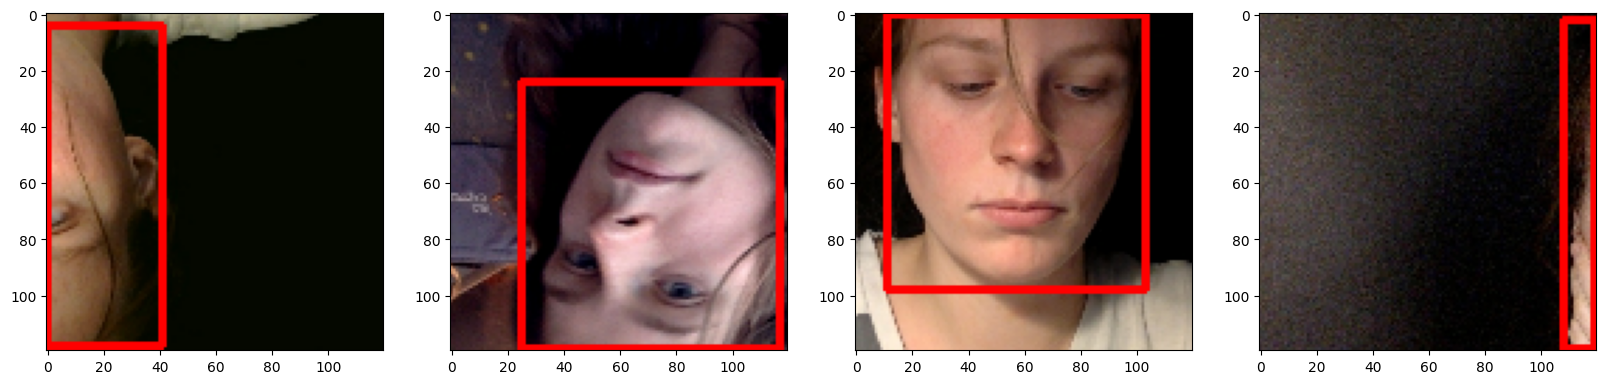

In [63]:
fif, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    # Normalizacja obrazu, zeby umozliwic wyswietlenie
    normalized_image_np = cv2.normalize(sample_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    sample_image_umat = cv2.UMat(normalized_image_np) 

    # Wywołanie funkcji cv2.rectangle na obiekcie UMat
    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image_umat,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255,0,0),2)

    # Wyświetlenie znormalizowanego obrazu
    ax[idx].imshow(sample_image_umat.get())
    

## 11.2 Save the Model

In [22]:
from tensorflow.keras.models import load_model

In [65]:
facetracker.save('facetracker.h5') #zapisz model w pliku facetracker.h5

In [23]:
facetracker = load_model('facetracker.h5') # wczytaj model z pliku

## 11.3 Real Time Detection  FINAL!!!!

In [16]:
# cap = cv2.VideoCapture(0) # 0 lub 1, tak jak na początku przy robieniu zdjęć
# while cap.isOpened():
#     _ , frame = cap.read()
#     frame = frame[50:500, 50:500, :]

#     rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     resized= tf.image.resize(rgb, (120,120))

#     yhat = facetracker.predict(np.expand_dims(resized/255,0))
#     sample_coords = yhat[1][0]

#     # Wyświetl
#     # jesli tutaj pojawia sie blad, mozliwe, ze trzeba znowrmalizowac, jak 4 okienka powyzej
#     if yhat[0] > 0.5:
#         # wyświtlenie głównego prostokąta?
#         cv2.rectangle(frame,tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),(255,0,0),2)
#         # wyświetlenie ramki
#         cv2.rectangle(frame,tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),[0,-30])),tuple(np.add(np.multiply(sample_coords[2:], [450,450]).astype(int),[80,0])),(255,0,0), 2)
#         # wyświetlenie tekstu
#         cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),[0,5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

#     cv2.imshow('EyeTrack', frame)

#     if cv2.waitKey(1) & 0xFF ==ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [24]:
cap = cv2.VideoCapture(0)  # 0 or 1, as in the beginning when taking pictures
while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    # Perform prediction
    classes, coords = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = coords[0]

    # Assuming classes is a one-hot encoded array
    class_idx = np.argmax(classes[0])
    confidence = classes[0][class_idx]
    print(classes[0][2])
    # If a face is detected with confidence above 0.5, assign the corresponding label
    if confidence > 0.5:
        if class_idx == 1 and classes[0][1] >0.85 and classes[0][1]>classes[0][2]:
            label = 'Asia'
        elif class_idx == 2 and classes[0][2] >0.85 and classes[0][1]<classes[0][2]:
            label = 'Ola'
        else:
            label = 'unknown'

        # Display with the corresponding label
        cv2.rectangle(frame, tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)), 
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)), (255, 0, 0), 2)
        cv2.rectangle(frame, tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -30])), 
                      tuple(np.add(np.multiply(sample_coords[2:], [450, 450]).astype(int), [80, 0])), (255, 0, 0), 2)
        cv2.putText(frame, label, tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, 5])), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
0.998329
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
0.99930453
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
0.9995449
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
0.99958926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
0.9988863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
0.99923587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
0.99985147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
0.99936396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
0.95242316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
0.9935621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
0.99784577
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
0.9982711
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
0.997129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
0.99510205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
0.9928732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
0.9959073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
0.9851409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
0.98136675
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
0.986158
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
0.96224517
1/1 ━━━━━━━━━━━━━━━━━━━━